# Fine-tune BLIP using Hugging Face `transformers`, `datasets`, `peft` 🤗 and `bitsandbytes`

Let's leverage recent advances from Parameter Efficient Fine-Tuning methods to fine-tune a large image to text model! We will show through this tutorial that it is possible to fine-tune a 3B scale model (~6GB in half-precision)

Here we will use a dummy dataset of [football players](https://huggingface.co/datasets/ybelkada/football-dataset) ⚽ that is uploaded on the Hub. The images have been manually selected together with the captions.
Check the 🤗 [documentation](https://huggingface.co/docs/datasets/image_dataset) on how to create and upload your own image-text dataset.

## Set-up environment

In [ ]:
!pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 14.0 MB/s eta 0:00:00


## Load the image captioning dataset

Let's load the image captioning dataset, you just need few lines of code for that.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("ybelkada/football-dataset", split="train")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/371 [00:00<?, ?B/s]

data/train-00000-of-00001-fc7c825a216873(…):   0%|          | 0.00/2.07M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6 [00:00<?, ? examples/s]

Let's retrieve the caption of the first example:

In [ ]:
dataset[0]["text"]

"Benzema after Real Mardid's win against PSG"

And the corresponding image

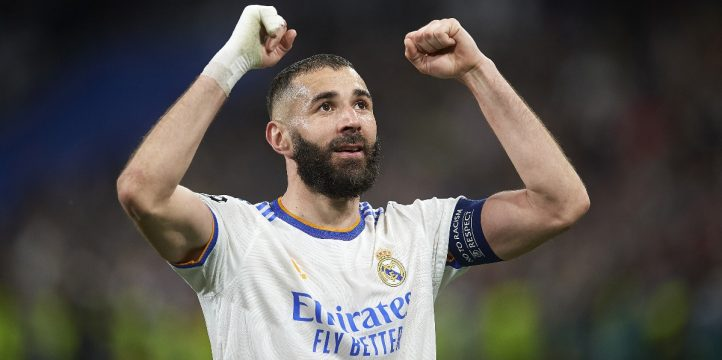

In [ ]:
dataset[0]["image"]

## Create PyTorch Dataset

Let's define below the dataset as well as the data collator!

In [ ]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor, max_length=128):
        self.dataset = dataset
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        # El processor ve imagen + texto
        encoding = self.processor(
            images=item["image"],
            text=item["text"],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )

        # quitamos la dimensión de batch (1, ...) → (...)
        encoding = {k: v.squeeze(0) for k, v in encoding.items()}

        # ya NO devolvemos "text" como string, todo está tokenizado
        return encoding

def collate_fn(batch):
    processed_batch = {}
    for key in batch[0].keys():
        processed_batch[key] = torch.stack([example[key] for example in batch])
    return processed_batch


## Load model and processor

In [ ]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration, BitsAndBytesConfig

quant_config = BitsAndBytesConfig(load_in_8bit=True)

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    device_map="auto",
    quantization_config=quant_config
)

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

Next we define our `LoraConfig` object. We explicitly tell

In [ ]:
from peft import LoraConfig, get_peft_model

# Let's define the LoraConfig
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"],
)
model = get_peft_model(model, config)

model.print_trainable_parameters()

trainable params: 5,242,880 || all params: 3,750,004,736 || trainable%: 0.1398


Now that we have loaded the processor, let's load the dataset and the dataloader:

In [ ]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=3,
    collate_fn=collate_fn,
)

## Train the model

Let's train the model! Run the simply the cell below for training the model

In [ ]:
import torch

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

model.train()

for epoch in range(200):
    print("Epoch:", epoch)
    for idx, batch in enumerate(train_dataloader):
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)
        pixel_values = batch["pixel_values"].to(model.device, torch.float16)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            labels=input_ids,
        )

        loss = outputs.loss
        print("Loss:", loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

Epoch: 0
Loss: 16.5
Loss: 15.453125
Epoch: 1
Loss: 14.8515625
Loss: 14.46875
Epoch: 2
Loss: 13.5078125
Loss: 12.2734375
Epoch: 3
Loss: 11.671875
Loss: 10.4609375
Epoch: 4
Loss: 9.3125
Loss: 7.73828125
Epoch: 5
Loss: 6.46875
Loss: 5.67578125
Epoch: 6
Loss: 5.33984375
Loss: 4.98046875
Epoch: 7
Loss: 4.6640625
Loss: 4.703125
Epoch: 8
Loss: 4.4609375
Loss: 4.2890625
Epoch: 9
Loss: 4.20703125
Loss: 4.04296875
Epoch: 10
Loss: 3.8984375
Loss: 3.6953125
Epoch: 11
Loss: 3.5
Loss: 3.3984375
Epoch: 12
Loss: 3.33203125
Loss: 3.099609375
Epoch: 13
Loss: 3.142578125
Loss: 2.814453125
Epoch: 14
Loss: 2.875
Loss: 2.599609375
Epoch: 15
Loss: 2.607421875
Loss: 2.466796875
Epoch: 16
Loss: 2.404296875
Loss: 2.2734375
Epoch: 17
Loss: 2.15234375
Loss: 2.177734375
Epoch: 18
Loss: 1.99609375
Loss: 2.14453125
Epoch: 19
Loss: 1.9208984375
Loss: 1.828125
Epoch: 20
Loss: 1.8134765625
Loss: 1.6943359375
Epoch: 21
Loss: 1.755859375
Loss: 1.6318359375
Epoch: 22
Loss: 1.6201171875
Loss: 1.5185546875
Epoch: 23
Loss: 1

## Inference

Let's check the results on our train dataset

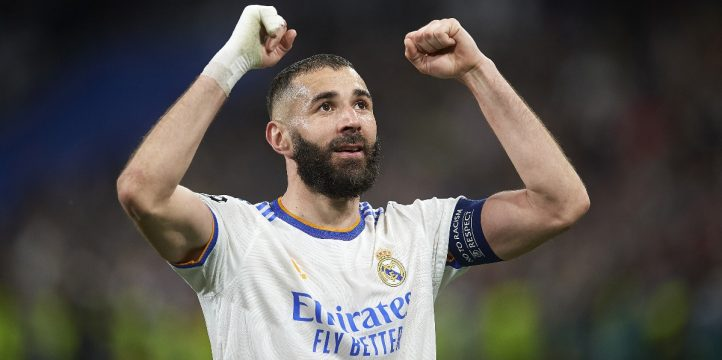

In [ ]:
# load image
example = dataset[0]
image = example["image"]
image

In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
pixel_values = inputs.pixel_values

generated_ids = model.generate(
    pixel_values=pixel_values,
    max_new_tokens=25,
)

generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0] # Setear skip_special_tokens=False
print(generated_caption)

Benzema after Real Mardid's win against PSG


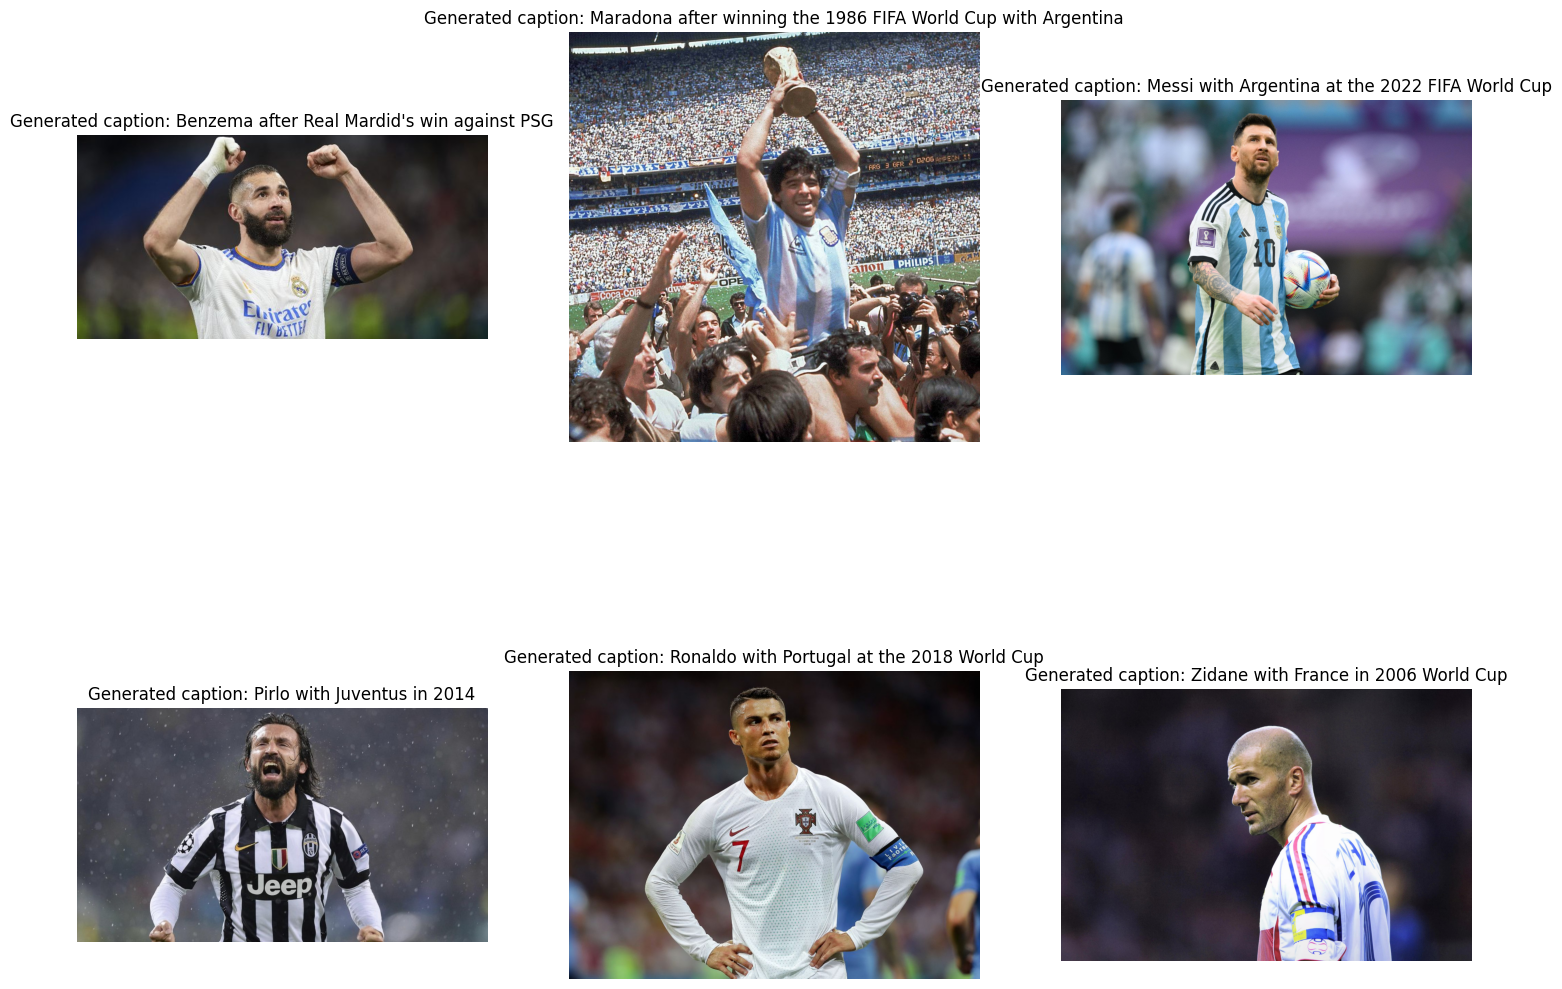

In [ ]:
import torch
from matplotlib import pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

fig = plt.figure(figsize=(18, 14))

# prepare image for the model
for i, example in enumerate(dataset):
    image = example["image"]

    inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
    pixel_values = inputs.pixel_values

    generated_ids = model.generate(
        pixel_values=pixel_values,
        max_new_tokens=25,
    )

    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    fig.add_subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Generated caption: {generated_caption}")

plt.show()